In [1]:
import torch
import torch.nn.functional as F
import torchvision.models as models
from torchvision import transforms
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt


In [2]:
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

img = cv2.imread('/kaggle/input/elephant-image/istockphoto-1452952557-612x612.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

img = Image.fromarray(img)

img_tensor = preprocess(img).unsqueeze(0)

In [3]:
model = models.resnet50(pretrained=True)
model.eval()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 154MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [4]:
target_layer = model.layer4[-1]

In [5]:
# Step 3: Identify the target layer
target_layer = model.layer4[-1]

# Initialize empty lists
activations = []
gradients = []

# Define the hooks
def forward_hook(module, input, output):
    activations.append(output)

def backward_hook(module, grad_input, grad_output):
    gradients.append(grad_output[0])

# Register the hooks
target_layer.register_forward_hook(forward_hook)
target_layer.register_full_backward_hook(backward_hook)


In [6]:
output = model(img_tensor)
pred_class = output.argmax(dim=1).item()


model.zero_grad()

In [7]:
output[:, pred_class].backward()
activations = activations[0].detach()
gradients = gradients[0].detach()

weights = torch.mean(gradients, dim=[2, 3])

grad_cam_map = torch.zeros(activations.shape[2:], dtype=torch.float32)

for i, w in enumerate(weights[0]):
    grad_cam_map += w * activations[0, i, :, :]

grad_cam_map = F.relu(grad_cam_map)

grad_cam_map -= grad_cam_map.min()
grad_cam_map /= grad_cam_map.max()
grad_cam_map = grad_cam_map.cpu().numpy()

In [8]:
heatmap = cv2.resize(grad_cam_map, (img.width, img.height))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

original_img = np.array(img)
superimposed_img = cv2.addWeighted(original_img, 0.6, heatmap, 0.4, 0)


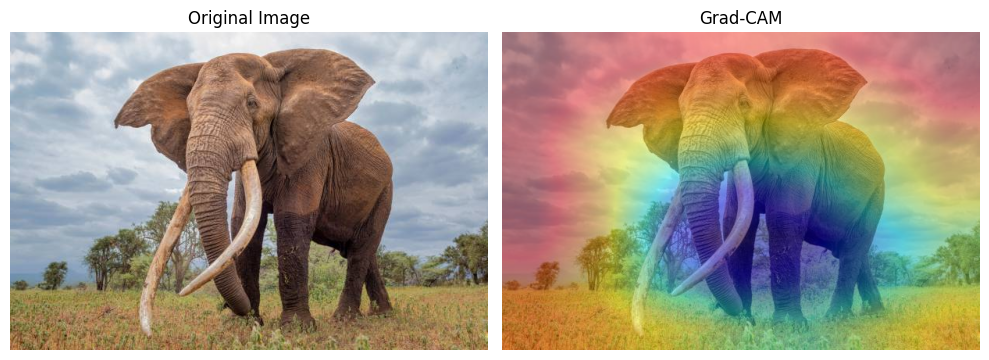

In [9]:
original_img = np.array(img)
superimposed_img = cv2.addWeighted(original_img, 0.6, heatmap, 0.4, 0)

# Plot the result
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(original_img)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Grad-CAM')
plt.imshow(superimposed_img)
plt.axis('off')

plt.tight_layout()
plt.show()